The Challenge
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, I built a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

The accuracy of the model is 0.77

In [62]:
import sklearn
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
from xgboost import cv
warnings.filterwarnings('ignore')

In [63]:
train=pd.read_csv('./train.csv')
test=pd.read_csv('./test.csv')
print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [64]:
# Start - Add new feature Ticket_type
train['Ticket_type']=train['Ticket'].apply(lambda x:x[0:3])
train['Ticket_type']=train['Ticket_type'].astype('category')
train['Ticket_type']=train['Ticket_type'].cat.codes

test['Ticket_type']=test['Ticket'].apply(lambda x:x[0:3])
test['Ticket_type']=test['Ticket_type'].astype('category')
test['Ticket_type']=test['Ticket_type'].cat.codes
# End

In [65]:
# Start - Add new feature Had_cabin
train['Cabin'].unique()
train['Had_Cabin']=train['Cabin'].apply(lambda x: 0 if type(x)==float else 1)
test['Had_Cabin']=test['Cabin'].apply(lambda x: 0 if type(x)==float else 1)
# End

In [66]:
# Start - Add new feature Family_size
train['Family_size']=train['SibSp']+train['Parch']+1
test['Family_size']=test['SibSp']+test['Parch']+1
# End

In [67]:
# Start - Deal null values
temp=pd.DataFrame(train.isnull().sum()).reset_index()
temp[temp[0]>0]['index']

# End

5          Age
10       Cabin
11    Embarked
Name: index, dtype: object

In [68]:
# Start - Group Embarked values
train.groupby('Embarked').size()
test.groupby('Embarked').size()
# End

Embarked
C    102
Q     46
S    270
dtype: int64

In [69]:
# Start - Handle missing values
train['Embarked'].fillna('S',inplace=True)
test['Embarked'].fillna('S',inplace=True)
train['Embarked']=train['Embarked'].astype('category')
test['Embarked']=test['Embarked'].astype('category')

mean_age=train['Age'].mean()
std_age=train['Age'].std()
na_count_age=train['Age'].isnull().sum()
na_rand_list=np.random.randint(mean_age-std_age,mean_age+std_age,size=na_count_age)
train.loc[train['Age'].isna(),'Age']=na_rand_list

mean_age=test['Age'].mean()
std_age=test['Age'].std()
na_count_age_t=test['Age'].isnull().sum()
na_rand_list_test=np.random.randint(mean_age-std_age,mean_age+std_age,size=na_count_age_t)
test.loc[test['Age'].isna(),'Age']=na_rand_list_test

train['Age']=train['Age'].astype(int)
test['Age']=test['Age'].astype(int)
# End

In [70]:
# Start - Map categorical values to integers
train['Embarked']=train['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)
train['Sex']=train['Sex'].map({'male':0,'female':1}).astype(int)

test['Embarked']=test['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)
test['Sex']=test['Sex'].map({'male':0,'female':1}).astype(int)
# End

In [71]:
# Start - Drop unnecessary columns
drop_cols=['PassengerId','Name','SibSp','Parch','Ticket','Cabin']
train=train.drop(drop_cols,axis=1)
PassengerId=test['PassengerId']
test=test.drop(drop_cols,axis=1)
# End

<AxesSubplot:>

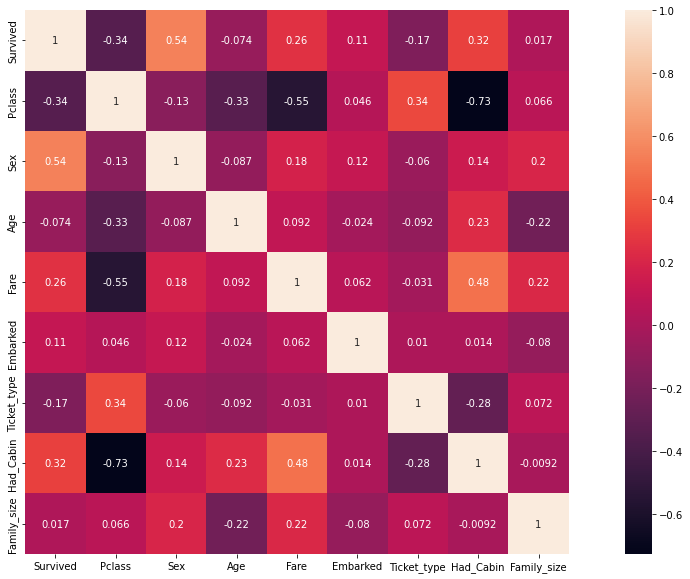

In [72]:
# Start - Check correlation matrix
plt.figure(figsize=(20,10))
sns.heatmap(train.corr(),square=True,annot=True)
# End

In [73]:
# Start - Model Building
y_train=train['Survived']
x_train=train.drop(['Survived'],axis=1)
x_test=test

params={
    'n_estimators':200,
    'objective':'binary:logistic',
    'max_depth':4,
    'learning_rate':0.1
}

model=xgb.XGBClassifier(**params).fit(x_train,y_train)
y_test=model.predict(x_test)
submission=pd.DataFrame({'PassengerId':PassengerId,'Survived':y_test})
submission.to_csv("submission.csv",index=False)
#End

[12:20:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
